Author of notebook: Mirjam Koedijk

Date of latest update: 02/07/2025.

In [1]:
import h5py
import numpy as np
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import json
import time
import scipy.sparse as sp

from scipy.integrate import solve_ivp
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from types import SimpleNamespace
from scipy.io import loadmat

In [2]:
plt.style.use('seaborn-v0_8-bright')
plt.rcParams.update({'font.size': 12})

# Running the Morrison-Young model
This is the python version of the Morrison-Young model, that was originally written in Julia and can be found here: https://github.com/mmtree/Celegans_premotor/tree/main

Article DOI: https://doi.org/10.48550/arXiv.2501.00278.

### Order of implementation
1. Defining the necessary functions
2. Importing and preparing data used for every model run
3. Importing and preparing data used for one specific model run
4. Setting the parameters and running the model

## 1. Defining the necessary functions

In [3]:
def relu(x):
    return np.maximum(0, x)

def data_replacement(i, nm, names_have, switchout_list, Dict_nms, ts_myneuros, 
                     dtsdt_myneuros, Fts1, dFts1dt):
    """
    Function that replaces missing timeseries of neurons with time series of neurons that are higly correlated.
    """
    if (len(nm) == 4) and (nm in switchout_list):
        print("switchout", nm)
        nm_new = None
        if nm[3] == "L":
            nm_new = nm[:3] + "R"
        elif nm[3] == "R":
            nm_new = nm[:3] + "L"
        
        if nm_new and nm_new in names_have:
            print(nm_new)
            ts_myneuros[i, :] = Fts1[Dict_nms[nm_new]]
            dtsdt_myneuros[i, :] = dFts1dt[Dict_nms[nm_new]]
        
        elif nm == "AVBL":
            print("AVBL isn't here and doesn't have twin")
            if "RIBL" in names_have:
                ts_myneuros[i, :] = Fts1[Dict_nms["RIBL"]]
                dtsdt_myneuros[i, :] = dFts1dt[Dict_nms["RIBL"]]
            elif "RIBR" in names_have:
                ts_myneuros[i, :] = Fts1[Dict_nms["RIBR"]]
                dtsdt_myneuros[i, :] = dFts1dt[Dict_nms["RIBR"]]
        
        elif nm == "AVBR":
            print("AVBR isn't here and doesn't have twin")
            if "RIBR" in names_have:
                ts_myneuros[i, :] = Fts1[Dict_nms["RIBR"]]
                dtsdt_myneuros[i, :] = dFts1dt[Dict_nms["RIBR"]]
            elif "RIBL" in names_have:
                ts_myneuros[i, :] = Fts1[Dict_nms["RIBL"]]
                dtsdt_myneuros[i, :] = dFts1dt[Dict_nms["RIBL"]]
        
        elif nm == "RIBL":
            print("RIBL isn't here and doesn't have twin")
            if "AVBL" in names_have:
                ts_myneuros[i, :] = Fts1[Dict_nms["AVBL"]]
                dtsdt_myneuros[i, :] = dFts1dt[Dict_nms["AVBL"]]
            elif "AVBR" in names_have:
                ts_myneuros[i, :] = Fts1[Dict_nms["AVBR"]]
                dtsdt_myneuros[i, :] = dFts1dt[Dict_nms["AVBR"]]
        
        elif nm == "RIBR":
            print("RIBR isn't here and doesn't have twin")
            if "AVBR" in names_have:
                ts_myneuros[i, :] = Fts1[Dict_nms["AVBR"]]
                dtsdt_myneuros[i, :] = dFts1dt[Dict_nms["AVBR"]]
            elif "AVBL" in names_have:
                ts_myneuros[i, :] = Fts1[Dict_nms["AVBL"]]
                dtsdt_myneuros[i, :] = dFts1dt[Dict_nms["AVBL"]]
        
        elif nm == "AIBL":
            print("AIBL isn't here and doesn't have twin")
            if "RIML" in names_have:
                ts_myneuros[i, :] = Fts1[Dict_nms["RIML"]]
                dtsdt_myneuros[i, :] = dFts1dt[Dict_nms["RIML"]]
            elif "RIMR" in names_have:
                ts_myneuros[i, :] = Fts1[Dict_nms["RIMR"]]
                dtsdt_myneuros[i, :] = dFts1dt[Dict_nms["RIMR"]]
        
        elif nm == "AIBR":
            print("AIBR isn't here and doesn't have twin")
            if "RIMR" in names_have:
                ts_myneuros[i, :] = Fts1[Dict_nms["RIMR"]]
                dtsdt_myneuros[i, :] = dFts1dt[Dict_nms["RIMR"]]
            elif "RIML" in names_have:
                ts_myneuros[i, :] = Fts1[Dict_nms["RIML"]]
                dtsdt_myneuros[i, :] = dFts1dt[Dict_nms["RIML"]]
    
    elif (len(nm) == 5) and (nm in switchout_list):
        print("switchout", nm)
        nm_new = None
        if nm[4] == "L":
            nm_new = nm[:4] + "R"
        elif nm[4] == "R":
            nm_new = nm[:4] + "L"
        
        if nm_new and nm_new in names_have:
            print(nm_new)
            ts_myneuros[i, :] = Fts1[Dict_nms[nm_new]]
            dtsdt_myneuros[i, :] = dFts1dt[Dict_nms[nm_new]]
    
    elif nm == "RID":
        if "AVBR" in names_have:
            ts_myneuros[i, :] = Fts1[Dict_nms["AVBR"]]
            dtsdt_myneuros[i, :] = dFts1dt[Dict_nms["AVBR"]]
        elif "AVBL" in names_have:
            ts_myneuros[i, :] = Fts1[Dict_nms["AVBL"]]
            dtsdt_myneuros[i, :] = dFts1dt[Dict_nms["AVBL"]]
            
    return

def Morrison_Young_model(t, u, A, d, W, gamma, beta, tau, Nsignals, ids_signal, Nmodel, Dsigs_interp, ids_core, a, fp1, 
                         fp2, fp3):
    
    # Get current Signal
    usig_tmp = [Dsigs_interp[i](t) for i in range(Nsignals)]
    usig_tmp = np.array(usig_tmp)
    
    # Combine signal and core neurons in one vector
    utmp = np.zeros(Nmodel)
    utmp[ids_core] = u
    utmp[ids_signal] = usig_tmp
    
    du_tmp = np.zeros(Nmodel)
    
    # Build matrix of utmp vector for easy subtraction
    ublock = np.tile(utmp[:, None], (1, Nmodel))
    ublockT = ublock.T
    
    # Calculate separate parts
    A_relu_u = A @ relu(utmp)
    
    diff = (ublock - ublockT).copy()
    W_u = np.diag(W @ diff)
    
    # Combine separate parts in the equation of the model
    du_tmp = (1/tau)*( a*(utmp-fp1)*(utmp-fp2)*(utmp-fp3) + d + beta * W_u + gamma * A_relu_u)

    du = np.zeros_like(u)
    du[:] = du_tmp[ids_core]  # Ensure same behavior
    
    
    return du

def plot_results(sol, title, save_as, save=False):
    """
    Plotting function. 
    """
    # Define colors and their corresponding labels
    colors = ['C0'] * 5 + ['C1'] * 2 + ['C2'] * 8
    labels = ['Forward'] * 5 + ['AVD'] * 2 + ['Reversal'] * 8

    # Create figure with desired aspect ratio
    plt.figure(figsize=(12, 3))

    # Dictionary to track which labels have been added to the legend
    legend_labels = {}

    # Plot each neuron with its corresponding color and add legend only once per category
    for i in range(sol.y.shape[0]):
        label = labels[i]
        if label not in legend_labels:
            plt.plot(sol.t, sol.y[i, :], color=colors[i], label=label)
            legend_labels[label] = True
        else:
            plt.plot(sol.t, sol.y[i, :], color=colors[i])

    plt.xlim(2,14)
    plt.ylim(-3, 3)
    plt.ylabel(r'$x_i(t)$')
    plt.xlabel(r'Time (minutes)')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if save:
        plt.savefig(save_as)
    plt.show()

## 2. Importing and preparing data used for every model run

In [4]:
##################################
### We start with White et al. ###
##################################
# Read csv file
df5 = pd.read_csv("Data/df5.csv")

### !! We import the final_neurons list from the Julia implementation to keep the same order !! ###
final_neurons = np.array(pd.read_csv("Data/final_neurons.csv")["Neuron"].tolist()) 
N = len(final_neurons)

# Create a dictionary mapping each neuron to an index
final_neuron_dict = {neuron: idx for idx, neuron in enumerate(final_neurons)}

df_EJ = df5[df5["Type"] == "EJ"]

# Build electrical junction matrix
EJ = np.zeros((N, N))

for _, row in df_EJ.iterrows():
    i = final_neuron_dict[row['Neuron1']]
    j = final_neuron_dict[row['Neuron2']]
    
    connection_type = row['Type']
    
    if connection_type == 'EJ':
        EJ[i,j] = row['Nbr']

###########################################
### Now we import the regression values ###
###########################################
file = h5py.File('Data/avg_model_weights.jld2', 'r')

# avg synapse values
A_approx = np.array(file['A_10takes_avg']).T

# avg d values
d_approx = np.array(file['d_10takes_avg']).T


###############################################
### Get the switchout-list from Atanas data ###
###############################################
# Below we determine which neurons are highly correlated and could be switch out for one other, when one of those neurons 
# lacks a time series in the dataset.

# Define data folder and filenames
data_folder = "Atanas_Data"

fn1 = "atanas_kim_2023-2023-03-07-01.json"
fn2 = "atanas_kim_2023-2023-01-23-21.json"
fn4 = "atanas_kim_2023-2023-01-19-22.json"
fn5 = "atanas_kim_2023-2023-01-19-15.json"  # avb
fn6 = "atanas_kim_2023-2023-01-19-08.json"  # avb
fn7 = "atanas_kim_2023-2023-01-19-01.json"  # avb
fn8 = "atanas_kim_2023-2023-01-17-14.json"
fn9 = "atanas_kim_2023-2023-01-17-07.json"
fn10 = "atanas_kim_2023-2023-01-16-22.json"  # avb, heat
fn11 = "atanas_kim_2023-2023-01-16-15.json"
fn12 = "atanas_kim_2023-2023-01-16-08.json"  # avb, heat
fn13 = "atanas_kim_2023-2023-01-10-14.json"  # avb, heat  
fn14 = "atanas_kim_2023-2023-01-10-07.json"  # avb, heat
fn15 = "atanas_kim_2023-2023-01-09-28.json"
fn16 = "atanas_kim_2023-2023-01-09-22.json"
fn17 = "atanas_kim_2023-2023-01-09-15.json"
fn18 = "atanas_kim_2023-2023-01-09-08.json"  # avb, heat
fn19 = "atanas_kim_2023-2023-01-06-15.json"
fn20 = "atanas_kim_2023-2023-01-06-08.json"
fn21 = "atanas_kim_2023-2023-01-06-01.json"
fn22 = "atanas_kim_2023-2023-01-05-18.json"  # avb, heat
fn23 = "atanas_kim_2023-2023-01-05-01.json"
fn24 = "atanas_kim_2023-2022-12-21-06.json"
fn25 = "atanas_kim_2023-2022-08-02-01.json"
fn26 = "atanas_kim_2023-2022-07-20-01.json"
fn27 = "atanas_kim_2023-2022-06-28-07.json"
fn28 = "atanas_kim_2023-2022-06-28-01.json"
fn29 = "atanas_kim_2023-2022-06-14-13.json"
fn30 = "atanas_kim_2023-2022-06-14-07.json"

# List of filenames
all_filenames = [fn1, fn2, fn4, fn5, fn6, fn7, fn8, fn9, fn10, fn11, fn12, fn13, fn14, fn15, fn16, fn17, fn18, fn19, fn20,
                 fn21, fn22, fn23, fn24, fn25, fn26, fn27, fn28, fn29, fn30]

num_files = len(all_filenames)

# Initialize correlation storage
cor_store = np.zeros((N, num_files))

fname_counter = 0  # file counter

# Loop through all files
for fname in all_filenames:
    filepath1 = os.path.join(data_folder, fname)
    
    with open(filepath1, 'r') as f:
        Fdata1 = json.load(f)
    
    labs = Fdata1["labeled"]
    Fts1 = Fdata1["trace_array"]
    key_set = labs.keys()
    Dict_nms = {}
    
    # Fill the dictionary with labels
    for ky in key_set:
        Dict_nms[labs[ky]["label"]] = int(ky)
    
    names_have = Dict_nms.keys()

    # Loop through final neurons
    for i, nm in enumerate(final_neurons):
        # Get two L/R time series to compare
        if nm in names_have:
            ts_tmp1 = Fts1[Dict_nms[nm]-1]

            # Normal length 4 neurons
            if len(nm) == 4:
                nm_new = ""
                if nm[3] == "L":
                    nm_new = nm[:3] + "R"
                elif nm[3] == "R":
                    nm_new = nm[:3] + "L"
                
                if nm_new in names_have:
                    ts_tmp2 = Fts1[Dict_nms[nm_new]-1]
                    cor_tmp = np.corrcoef(ts_tmp1, ts_tmp2)[0, 1]  # Compute correlation
                    cor_store[i, fname_counter] = cor_tmp
            
            # Length 5 neurons
            elif len(nm) == 5:
                nm_new = ""
                if nm[4] == "L":
                    nm_new = nm[:4] + "R"
                elif nm[4] == "R":
                    nm_new = nm[:4] + "L"
                
                if nm_new in names_have:
                    ts_tmp2 = Fts1[Dict_nms[nm_new]-1]
                    cor_tmp = np.corrcoef(ts_tmp1, ts_tmp2)[0, 1]  # Compute correlation
                    cor_store[i, fname_counter] = cor_tmp
        
    fname_counter += 1

# Compute the mean correlation list
cor_mean_list = np.zeros(N)
for i in range(N):
    tmp_row = cor_store[i, :]
    if np.sum(tmp_row) != 0:
        idx_tmp = np.where(tmp_row != 0)
        cor_vals_tmp = tmp_row[idx_tmp]
        cor_mean_list[i] = np.mean(cor_vals_tmp)

# Final list of highly correlated neurons
highly_correlated_neurons = [final_neurons[i] for i in range(N) if cor_mean_list[i] > 0.7]  # 75%

# Final switchout list
switchout_list = ["AVBL", "AVBR"] + highly_correlated_neurons

# Save the list so we don't need to repeat this for other notebooks:
# np.save("switchoutlist.npy", switchout_list)

## 3. Importing and preparing data used for one specific model run

In [5]:
##########################################################
### 1. Getting the neurons and ts from the Atanas data ###
##########################################################

#!# This is the data preparation you can use if do not need to have the same order as the original Julia implementation #!#
# Initialize data
with open('Atanas_Data/atanas_kim_2023-2023-01-23-15.json') as f:
    atanas_data = json.load(f)

labs = atanas_data["labeled"]
Fts1 = atanas_data["trace_array"]
dt = round(atanas_data["avg_timestep"], 3)
dFts1dt = [0] * (len(Fts1)) # Initialize derivative storage
Fts1_new = [0] * (len(Fts1))

### Make the data smooth
for i in range(len(Fts1)):
    ts_tmp = savgol_filter(Fts1[i], 11, 5)  # Apply Savitzky-Golay filter
    ts_tmp_chop1 = ts_tmp[2:]  
    ts_tmp_chop2 = ts_tmp[:-2] 
    dts_dt_tmp = (ts_tmp_chop1 - ts_tmp_chop2) / (2 * dt)  # Compute derivative

    ts_tmp_mid = ts_tmp[1:-1] 
    Fts1_new[i] = ts_tmp_mid
    dFts1dt[i] = dts_dt_tmp

Fts1 = Fts1_new.copy()

# Create dictionary mapping labels to indices
# Dict_nms = {labs[ky]["label"]: int(ky) for ky in labs.keys()}
with open("Data/dict_nms.json", "r") as f:
    Dict_nms = json.load(f)

Dict_nms = {key: value - 1 for key, value in Dict_nms.items()}
# Get available label names, these are all the neurons from the Atanas dataset
names_have = Dict_nms.keys()

# Determine time series length
ts_len = len(Fts1[1])

##########################################################################
### 2. Go through final_neurons and collect the ts for those available ###
##########################################################################

# Initialize arrays
ts_myneuros = np.zeros((N, ts_len))
dtsdt_myneuros = np.zeros((N, ts_len))

# Counter
i = 0  # Python uses 0-based indexing
for nm in final_neurons:
    if nm in names_have:
        ts_myneuros[i, :] = Fts1[Dict_nms[nm]]
        dtsdt_myneuros[i, :] = dFts1dt[Dict_nms[nm]]
    else:
        # Data Replacement
        data_replacement(i, nm, names_have, switchout_list, Dict_nms, ts_myneuros, 
                                                       dtsdt_myneuros, Fts1, dFts1dt)
    
    i += 1  # Move to the next row

# Pre for regression
# D = np.copy(ts_myneuros)  # Timeseries of all neurons in order of "final_neurons" (many rows zero, no data for them)
# dDdt = np.copy(dtsdt_myneuros)  # Derivative timeseries

#!# Data prep until here, below we load in the prepared data from the Julia implementation #!#

D = np.load("Data/D.npy")
dDdt = np.load("Data/dDdt.npy")

### Get short D matrix
row_sum = np.sum(D, axis=1)
idxfull_list = []

# Get index of nonzero rows (final_neurons that have a timeseries)
for i in range(len(row_sum)):
    if row_sum[i] != 0:
        idxfull_list.append(i)
        
# Number of final_neurons that have a timeseries
print(f"Number of neurons with a timeseries = {len(idxfull_list)}")

##################################################
### 3. Get submatrices with only model neurons ###
##################################################

### Model neurons - named and timeseries - short block 
model_neurons = final_neurons[idxfull_list]
Nmodel = len(model_neurons)

ids_model = []
for neuron in model_neurons:
    ids_model.append(final_neuron_dict[neuron])

Dmodel = D[ids_model, :]
dDdtmodel = dDdt[ids_model, :]
model_neurons_dict = {model_neurons[i]: i for i in range(Nmodel)}  # Create the dictionary with model neuron indices

switchout SMBDL
switchout AVBR
AVBL
switchout RIBR
RIBL
switchout AVKR
switchout AVKL
switchout SMBVL
switchout SMBVR
switchout BAGL
switchout SMBDR
switchout BAGR
Number of neurons with a timeseries = 84


## 4. Setting the parameters and running the model

In [6]:
####################
### 1. Parameters ###
#####################

fp1 = -0.8
fp2 = 0.1
fp3 = 1
a = -2

gamma = 1.4
beta = 10
tau = 0.2

d_model = d_approx[ids_model]

# Get Chemical synapse for model neurons
A_model = np.zeros((Nmodel,Nmodel))

for i in range(Nmodel):
    for j in range(Nmodel):
        A_model[i, j] = A_approx[ids_model[i], ids_model[j]]

# Get gap junction for model neurons
W_model = np.zeros((Nmodel,Nmodel))

for i in range(Nmodel):
    for j in range(Nmodel):
        W_model[i, j] = EJ[ids_model[i], ids_model[j]]
        
# Define the core neurons
core_neurons = ["AVBL","AVBR","RIBL","RIBR","RID", "AVDL", "AVDR", "AVAL", "AVAR", "RIML", "RIMR","AVEL","AVER",
                "AIBL","AIBR"]

###############################
### 2. Get the input signal ###
###############################

#time_vec = np.arange(0, 100 + dt, dt)

# Be careful that in original code ids_core is something different!!
ids_core = [model_neurons_dict[neuron] for neuron in core_neurons] 

Ncore = len(ids_core)

# Nmodel is the total number of neurons in the dataset with a time serie
ids_signal = list(set(range(Nmodel)) - set(ids_core))
Nsignals = len(ids_signal)

### Get signals
tstart = 4  # Time start: tstart = 5, 100, 600, 900
Dmodel_cut = Dmodel[:, tstart:]  # Cut the data matrix from tstart to end
Dsignals = Dmodel_cut[ids_signal, :]
Dcore = Dmodel_cut[ids_core, :]
u0 = Dcore[:, 0]  # Initial condition (first timepoint of core neurons)

num_steps = 1590
t_short = dt * np.arange(0, num_steps + 1)

### Get interpolations for the signal timeseries
Dsigs_interp = []
for i in range(Nsignals):
    itp = interp1d(t_short, Dsignals[i, :num_steps+1], kind='linear', fill_value="extrapolate", bounds_error=False)
    Dsigs_interp.append(itp)

# Timespan for the ODE
tspan = (0.0, t_short[-1])  # Timespan for ODE

In [7]:
# Solve the ODE
start = time.time()
sol_EJ_Syn = solve_ivp(Morrison_Young_model, tspan, u0, args=(A_model, d_model, W_model, gamma, 10, tau, Nsignals, 
                                                              ids_signal, Nmodel, Dsigs_interp, ids_core, a, fp1, fp2, 
                                                              fp3), 
                       t_eval=t_short, dense_output=False, method='RK45')
end = time.time()

print("Took %f min" % ((end - start) / 60) )

Took 0.859590 min


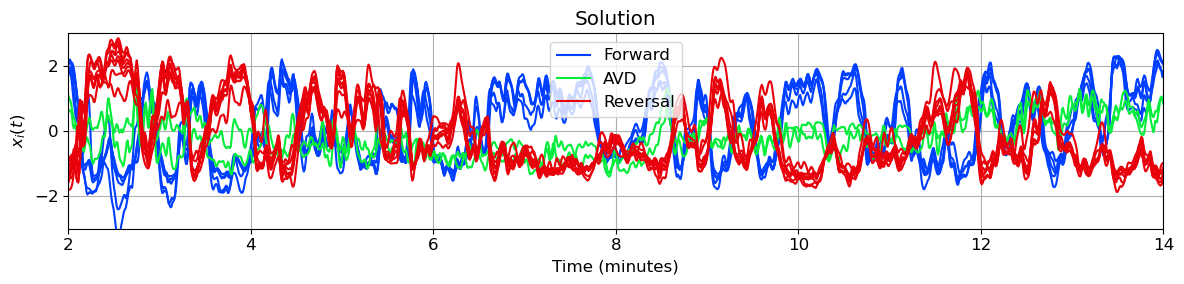

In [8]:
# Plot the results
plot_results(sol_EJ_Syn, 'Solution', 'MY_sol.pdf', False)

# Calculating Lyapunov spectrum
Includes the method of finding Lyapunov exponents using the Jacobian from the model-equations. This method is derived from the paper by Engelken et al. (2023) (DOI: https://doi.org/10.1103/PhysRevResearch.5.043044).

### Order of implementation
1. Defining the necessary functions
2. Combining solution with data
3. Find and plot spectrum

## 1. Defining the necessary functions

In [9]:
def deriv_f(x):
    
    deriv = -2*(x - 0.1)*(x - 1) - 2*(x + 0.8)*(x - 1) - 2*(x + 0.8)*(x - 0.1)
    
    return deriv

def deriv_relu(x):
    if x > 0:
        y = x
    else:
        y = 0
    return y

def jacobian(h, beta, gamma, A, W, ids_core, nmb_neurons):
    D = np.zeros((nmb_neurons, nmb_neurons))
    
    for i in range(nmb_neurons):
        for j in range(nmb_neurons):
            if (i in ids_core) and (j in ids_core):
                if i == j:
                    D[j,i] =  gamma*A[i,j]*deriv_relu(h[j]) + deriv_f(h[i]) - beta*np.sum(W[i,:])
                else:
                    D[j,i] = beta*W[i,j] + gamma*A[i,j]*deriv_relu(h[j])
            if (i in ids_core) and (j not in ids_core):
                    D[j,i] = beta*W[i,j] + gamma*A[i,j]*deriv_relu(h[j])
    return D

def Jacobian_based_lyap(sol, A, W, beta, gamma, ids_core, t_trans, N, jac):
    t = sol.t
    H = sol.y
    
    t_sim = t[-1] - t[0]
    
    M = len(t)
    
    D = np.zeros((N, N))
    
    Q, R = np.linalg.qr(np.random.randn(N,N))
    lyap = np.zeros(N)
    
    for k in range(M-1):
        dt = t[k+1] - t[k]
        h = H[:, k] + dt*H[:, k + 1]
        
        D = np.eye(N) + dt*jac(h, beta, gamma, A, W, ids_core, N)
        
        Q = np.dot(D, Q)
        
        if t[k] > t[0] + t_trans:
            if k % 1 == 0:
                
                Q, R = np.linalg.qr(Q)
                lyap += np.log(np.abs(np.diag(R)))
    
    return lyap / (t_sim - t_trans) / 60

## 2. Combining solution with data

In [10]:
t_interp = sol_EJ_Syn.t

# Get the datavalues at the time points of the solution
interpolated_values = np.array([f(t_interp) for f in Dsigs_interp])

# Total number of rows in the combined solution
n_total = len(ids_core) + len(ids_signal)
n_timepoints = sol_EJ_Syn.y.shape[1]

# Initialize the combined array with NaNs to detect mistakes
combined_y = np.full((n_total, n_timepoints), np.nan)

# Fill in core solution values at positions in ids_core
for src_idx, dest_idx in enumerate(ids_core):
    combined_y[dest_idx] = sol_EJ_Syn.y[src_idx]

# Fill in interpolated signals at positions in ids_signal
for src_idx, dest_idx in enumerate(ids_signal):
    combined_y[dest_idx] = interpolated_values[src_idx]

# Wrap into a new solution-like object
sol_combined = SimpleNamespace(t=sol_EJ_Syn.t, y=combined_y)

## 3. Find and plot spectrum

In [11]:
# time parameters
dt_Lyap = 0.01
t_trans = 1

In [12]:
Lyap = Jacobian_based_lyap(sol_combined, A_model, W_model, beta, gamma, ids_core, t_trans, 84, jacobian)

The maximal lyapunov exponent is 0.004114254296769333


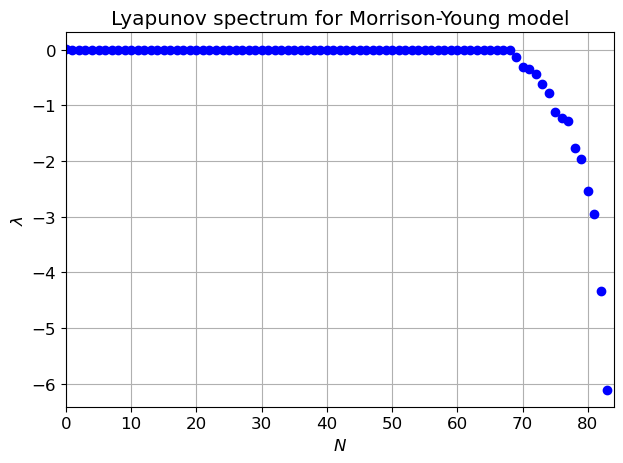

In [13]:
print("The maximal lyapunov exponent is", max(Lyap))

plt.plot(Lyap, 'ob')
plt.title("Lyapunov spectrum for Morrison-Young model")
plt.xlim(0, 84)
plt.ylabel(r"$\lambda$")
plt.xlabel("$N$")
plt.grid(True)
plt.tight_layout()
#plt.savefig('LS_full_data.pdf')
plt.show()